# MiniGPT For Generating Synthetic Text Data

by Kris Smith

# ***WARNING*** 

## The data required to train the model for this task is known to be vulgar, offensive, toxic, racist, and otherwise not pleasant.

## Problem Statement

Toxic comments online come in many forms and in many arenas. There are currently several ways to mitigate these comments(for those organizations who wish to do so). Some of these ways include human moderators, and training machine learning models to detect toxicity in online comments.

The issue with human moderators is that some of these platforms have grown so large so quickly that there are not nearly enough moderators to achieve any sense of control for most of these comments. The shear volume of toxicity and bots online makes it unrealistic to think we could do this job with humans at this point.

Many companies are employing machine learning to assist with identifying toxic comments online automatically. The problem with this approach is the lack of labeled training data to train the models on.

This is the problem I am going to solve using generative deep learning techniques. 

## References

* [Improving Language Understanding by Generative Pre-Training](https://www.semanticscholar.org/paper/Improving-Language-Understanding-by-Generative-Radford-Narasimhan/cd18800a0fe0b668a1cc19f2ec95b5003d0a5035)

* [Language Models are Unsupervised Multitask Learners](https://www.semanticscholar.org/paper/Language-Models-are-Unsupervised-Multitask-Learners-Radford-Wu/9405cc0d6169988371b2755e573cc28650d14dfe)

* [Language Models are Few-Shot Learners](https://arxiv.org/abs/2005.14165)

* Many of the ideas and code were adapted from this Keras resource: https://keras.io/examples/generative/text_generation_with_miniature_gpt/

## Import Libraries

In [1]:
import os
import string
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from nltk import ngrams
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Data

The data I will be using to train the generative model was released on Kaggle as part of an ongoing series of competitions sponsored by the [Google company Jigsaw](https://en.wikipedia.org/wiki/Jigsaw_(company)).

The data consists of online comments with various severity levels of toxicity. There are versions of these comments labeled by human annotators wherein they label each comment as toxic or not, or other sets where they were labeled as different categories of toxic such as hatespeech, racist/sexist, obscene, etc. Although these are the labeled datasets we would be adding the synthetic data to in order to create more training data, for this task of simply generating similar text data we will only focus on the comments themselves.

The data provided by this competition includes a total of `14,251` unique toxic comments. Theses are the comments I will use to train the generative model with.

## EDA

The data came in two different files.

1) Comments to score: This acts as a test dataset of comments for scoring after the model was trained.

2) Validation data: This was the training data for the competition wherein there are two columns. One column labeled less toxic was a comment which human annotators labeled as less toxic than its more toxic counterpart in the other column. There was no actual training data where a comment was paired with its severity rating. The models were trained using creative techniques with the validation data and other classification data sets to train a model which predicted severity of comments.

Since for our purposes we are only interested in the actual text comments themselves, I will only be using those columns from these datasources.

I start by reading them all into pandas dataframes, isolating the text columns from each one, and stacking them all together so we have a single column of text when it is all said and done.


In [2]:
data1 = pd.read_csv('../input/jigsaw-toxic-severity-rating/comments_to_score.csv')
data1.info()

## Isolate only text column
data1 = data1['text']

data1.sample(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7537 entries, 0 to 7536
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  7537 non-null   int64 
 1   text        7537 non-null   object
dtypes: int64(1), object(1)
memory usage: 117.9+ KB


5588                  Important \ndo you spit or swallow?
1653                                CHickens has no penis
6699     Learn to read \n\nAnd stop being a surly pric...
4725    "\n\nIf you don't believe me, go look at the s...
1447     Ban me for what ?\nYou cant put me on my fina...
1860    Meeples is a joke account.  Please disregard e...
Name: text, dtype: object

We can see the comments to score was the test file which contained only comments and their corresponding id's

In [3]:
data2 = pd.read_csv('../input/jigsaw-toxic-severity-rating/validation_data.csv')
data2.info()

data2.sample(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30108 entries, 0 to 30107
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   worker      30108 non-null  int64 
 1   less_toxic  30108 non-null  object
 2   more_toxic  30108 non-null  object
dtypes: int64(1), object(2)
memory usage: 705.8+ KB


,worker,less_toxic,more_toxic
8184,349,"""\n\nAm I the only one who thinks this article...",Niteshift you are one seriously ignorant indiv...
20462,615,"Marie Luv \n\n 20:18, 2 September 2009 (hist)...","Take a break. \n\nTake a break, Culver. What ..."
13424,633,Everybody lock ur dicks cuz theyre gay!!!,"""\n\nUseless\nThis page is not helpful to Wiki..."
1809,634,CHickens has no penis,You are a Problem\n\nyour probably some freshm...
7143,157,I am a stupid bitch who needs shutting the fuc...,"""\nYou are a biased Columbia grad with a COI. ..."
14091,201,"""\n\n Wealth and Justice sections \n\nThese tw...",wtf is this\nconfusing why cant peope have the...


This was the data provided to validate the models performance during training. The three columns are workers(annotators) and the other two are text columns which we will use both to train our generative model with.

#### Combine all columns into a single column

In [4]:
## Isolate text column
data2 = data2['more_toxic']

## Isolate text column
data3 = pd.read_csv('../input/jigsaw-toxic-severity-rating/validation_data.csv')
data3 = data3['less_toxic']

text_column = pd.concat([data1, data2, data3], axis=0, ignore_index=True)

#### Check for duplicates

In [5]:
text_column.value_counts()

 sorry i jumped to conclusions \n\non christian terrorism article man, I don't agree with you, and I want you to go and listen to 'prophet of doom' (now in audio format) as it is good. But I was wrong to be so rude. It is not the Southern European way.                                                                                                                                                                               19
this irishtom guy is turning every article into an ad for islam                                                                                                                                                                                                                                                                                                                                                                            19
You are not sorry one damned bit.  You have yet to refute what I have written.  All you do is pass the insults as if it were salt on the din

It looks like between the data provided for the competition there are many duplicates. However we can see that some comments are reused many more times than other comments. For example the most used comments were repeated `19` times in the datasets while others only `2` times. 

Since the duplications are not balanced if we left the data like this I am afraid we would be biasing the model towards the comments which were present more in the data. 

I will remove all duplicate comments.

In [6]:
print(f"Total numer of comments in text data = {len(text_column)}")
print(f"Numer of unique comments in text data = {len(text_column.unique())}")

text_column = text_column.drop_duplicates()
print("Duplicate comments dropped")

Total numer of comments in text data = 67753
Numer of unique comments in text data = 14251
Duplicate comments dropped


### Exploring the toxic comments

In [7]:
data = pd.DataFrame()
data['text'] = text_column
data = data.sample(100)

# Function to calculate word count
def count_words(text):
    words = nltk.word_tokenize(text)
    return len(words)

# Function to calculate verb count
def count_verbs(text):
    words = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(words)
    verb_count = len([word for word, tag in tagged_words if tag.startswith('V')])
    return verb_count

# Function to calculate noun count
def count_nouns(text):
    words = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(words)
    noun_count = len([word for word, tag in tagged_words if tag.startswith('N')])
    return noun_count

# Add word count column
data['word_count'] = data['text'].apply(count_words)

# Add verb count column
data['verb_count'] = data['text'].apply(count_verbs)

# Add noun count column
data['noun_count'] = data['text'].apply(count_nouns)

data.describe()

,word_count,verb_count,noun_count
count,100.000000,100.00000,100.000000
mean,83.160000,13.85000,19.300000
std,119.187292,19.15296,29.181598
min,4.000000,0.00000,1.000000
25%,23.000000,3.00000,5.000000
50%,50.000000,8.00000,10.000000
75%,91.500000,15.25000,15.250000
max,965.000000,144.00000,209.000000


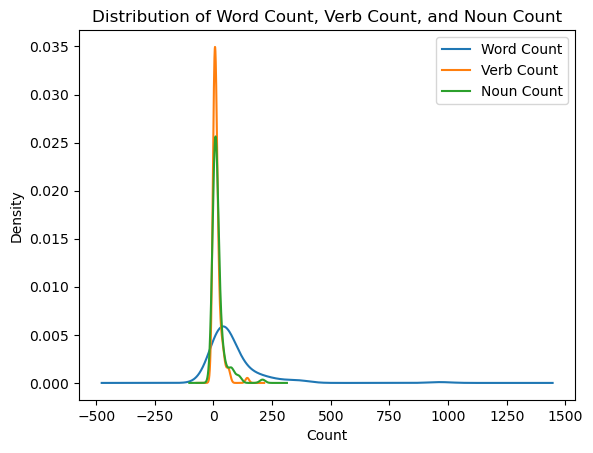

In [8]:
ax = data['word_count'].plot(kind='kde')
data['verb_count'].plot(kind='kde', ax=ax)
data['noun_count'].plot(kind='kde', ax=ax)

ax.legend(['Word Count', 'Verb Count', 'Noun Count'])
ax.set_title('Distribution of Word Count, Verb Count, and Noun Count')
ax.set_xlabel('Count')
ax.set_ylabel('Density')

plt.show()

We can see that these comments on average are quite short in length and contain more nouns than verbs on average.

Since we have not done any cleaning of the data yet these distributions are not exact as the nltk package is not currently looking for misspelled words or different versions of word spellings which are used online sometimes.

For example if a user knows that the platform they are on has limitations on language than they may spell a profane word to try to fool any auto detecting systems such as `Fuck==>Fxck, F*ck, Fukk, Fuuu*uukk`, etc.

Therefore these counts will not detect all nouns and verbs but should give a decent sample.

Knowing the underlying distributions of some of these features is important because after the synthetic data is generated we would most likely want it to follow the same distributions for these attributes of the text. 

### Looking at the most common N-grams

In [9]:
# Tokenize the text into words
data['words'] = data['text'].apply(nltk.word_tokenize)

# Get bigrams and trigrams for each row
data['bigrams']   = data['words'].apply(lambda x: list(ngrams(x, 2)))
data['trigrams']  = data['words'].apply(lambda x: list(ngrams(x, 3)))
# data['quadgrams'] = data['words'].apply(lambda x: list(ngrams(x, 4)))

# Count the occurrences of bigrams and trigrams
bigram_counts   = Counter([gram for grams in data['bigrams'] for gram in grams])
trigram_counts  = Counter([gram for grams in data['trigrams'] for gram in grams])
# quadgram_counts = Counter([gram for grams in data['quadgrams'] for gram in grams])

# Get the most common bigrams, trigrams, and quadgrams
most_common_bigrams   = bigram_counts.most_common(50)
most_common_trigrams  = trigram_counts.most_common(50)
# most_common_quadgrams = quadgram_counts.most_common(50)

df_common_grams = pd.DataFrame()
df_common_grams['bigrams']   = most_common_bigrams
df_common_grams['trigrams']  = most_common_trigrams
# df_common_grams['quadgrams'] = most_common_quadgrams

# # Display the results
# print('Most common bigrams:')
# for bigram, count in most_common_bigrams:
#     print(' '.join(bigram), count)

# print('\nMost common trigrams:')
# for trigram, count in most_common_trigrams:
#     print(' '.join(trigram), count)
    
# print('\nMost common quadgrams:')
# for quadgram, count in most_common_quadgrams:
#     print(' '.join(quadgram), count)


df_common_grams.iloc[:, :]

,bigrams,trigrams
0,"(('', ''), 69)","(('', '', .), 10)"
1,"((``, ''), 58)","((I, do, n't), 9)"
2,"((,, and), 34)","((., '', ''), 9)"
3,"((of, the), 30)","((I, 'm, not), 8)"
4,"((., I), 29)","(('', '', and), 7)"
5,"((I, 'm), 22)","((a, ``, ''), 7)"
6,"((., The), 21)","(((, Family_Guy, )), 7)"
7,"((do, n't), 20)","((., I, 'm), 6)"
8,"((in, the), 19)","(('', '', ,), 6)"
9,"((is, a), 18)","((,, but, I), 5)"


We can see the initial 10 or so most common bi-grams and tri-grams are repetitive punctuation marks.

Traditionally these would be cleaned and removed when training models for NLP tasks, however due to the nature of this work many of these traditional techniques will limit the models ability to predict toxicity as well as with clean text.

I happened to have competed in this competition and one thing all of us learned was that leaving capital letters and punctuation improved the models ability to infer toxicity and especially levels of toxicity. 

For example a phrase such as:

`Are you kidding?`

Conveys a much different meaning than the same words but put this way:

`ARE YOU KIDDING!!!??`

Traditional NLP techniques would have us convert all characters to lower case and remove punctuation so the model will interpret both of those texts the exact same way.

When training sentiment based models or models where feeling and emotion is being conveyed in some way such as toxicity of comments, it is more than just the raw content of the words alone which gives the meaning. The puncuation and capitalizations are very expressive forms of language and as such for these problems do better left in the data.

## Pre-Processing

* First we need load in our text column as tensorflow formatted dataset

* Next we shuffle the data to avoid any patterns which may have been present

* We then slice the data into batches for processing

* Vectorize the text which will be used to create a corpus of vocabulary used when training and act as vector representations of our text

* Create the corpus of vocabulary which is used to train and evaluate throughout

In [10]:
vocab_size = 20000  ## Only consider the top 20k words
maxlen = 80  ## Max sequence length
batch_size = 32  ## Data loading batch sizes

# Create a dataset from the pandas column
text_ds = tf.data.Dataset.from_tensor_slices(text_column)

# Shuffle and batch the dataset
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)

# def custom_standardization(input_string):
#     """ Remove html line-break tags and handle punctuation """
#     lowercased = tf.strings.lower(input_string)
#     stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
#     return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


## Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  ## To get words back from token indices

## Generate Labels

Since we are building a generative auto-regressive model, we must train it to predict the next word by looking backwards and using the previous tokens to predict the highest probability for the next token.

This is fairly easy to create labels for because we simply shuffle the `TRUE` data be one token and then when training the model compares the predicted text with the next indexed word.

We can inspect what these samples and labels look like below:

In [11]:
## Function to create target column
def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


text_ds = text_ds.map(prepare_lm_inputs_labels)
text_ds = text_ds.prefetch(tf.data.AUTOTUNE)

In [12]:
## Select samples from the training data set to inspect
sample = text_ds.take(5) 

## Display some samples
for x, y in sample:
    # Convert token indices back to words
    input_words  = [vocab[i] for i in x[0].numpy()]
    target_words = [vocab[i] for i in y[0].numpy()]

    print("\n\n\n\nInput Sequence:")
    print(" ".join(input_words))
    print("\nTarget Sequence:")
    print(" ".join(target_words))





Input Sequence:
You are a racist pig, loser. Don't vandalize again. [UNK] 28 Jan 2005 (UTC)                                                                  

Target Sequence:
are a racist pig, loser. Don't vandalize again. [UNK] 28 Jan 2005 (UTC)                                                                   




Input Sequence:
You [UNK] are all just [UNK] wannabes ! None of you have contributed one word to the Dog fighting article and none of you even know about Dog [UNK] Any Of You Know Have Any [UNK] I Can [UNK]                                         

Target Sequence:
[UNK] are all just [UNK] wannabes ! None of you have contributed one word to the Dog fighting article and none of you even know about Dog [UNK] Any Of You Know Have Any [UNK] I Can [UNK]                                          




Input Sequence:
[UNK] claim I am most certainly not a sockpuppet of [UNK] please retract your [UNK] claim at once.                                                              



* ***We can see that the target or label sequence is merely our ground truth text sequence we have just shifted by `1` token. This is what our model will use to evaluate during training.***

* ***Cell below was for loading in and preprocessing the IMBD movie quotes dataset. This is the dataset I tested this approach on first.***

In [13]:
# !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xf aclImdb_v1.tar.gz

# batch_size = 128

# # The dataset contains each review in a separate text file
# # The text files are present in four different folders
# # Create a list all files
# filenames = []
# directories = [
#     "aclImdb/train/pos",
#     "aclImdb/train/neg",
#     "aclImdb/test/pos",
#     "aclImdb/test/neg",
# ]
# for dir in directories:
#     for f in os.listdir(dir):
#         filenames.append(os.path.join(dir, f))

# print(f"{len(filenames)} files")

# # Create a dataset from text files
# random.shuffle(filenames)
# text_ds = tf.data.TextLineDataset(filenames)
# text_ds = text_ds.shuffle(buffer_size=256)
# text_ds = text_ds.batch(batch_size)

# def custom_standardization(input_string):
#     """ Remove html line-break tags and handle punctuation """
#     lowercased = tf.strings.lower(input_string)
#     stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
#     return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# # Create a vectorization layer and adapt it to the text
# vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
#     max_tokens=vocab_size - 1,
#     output_mode="int",
#     output_sequence_length=maxlen + 1,
# )
# vectorize_layer.adapt(text_ds)
# vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

# ## Functoin to create target column
# def prepare_lm_inputs_labels(text):
#     """
#     Shift word sequences by 1 position so that the target for position (i) is
#     word at position (i+1). The model will use all words up till position (i)
#     to predict the next word.
#     """
#     text = tf.expand_dims(text, -1)
#     tokenized_sentences = vectorize_layer(text)
#     x = tokenized_sentences[:, :-1]
#     y = tokenized_sentences[:, 1:]
#     return x, y


# text_ds = text_ds.map(prepare_lm_inputs_labels)
# text_ds = text_ds.prefetch(tf.data.AUTOTUNE)

## Implement the Transformer Block and Attention Head

In [58]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Creates a mask for causal (auto-regressive) self-attention. The returned mask has the shape 
    [batch_size, n_dest, n_src], where each entry at position (i, j, k) will be 1 if j >= k and 0 otherwise. 
    This is used to prevent the attention mechanism from attending to future positions during the forward pass.

    Args:
        batch_size (int): Number of sequences in each batch.
        n_dest (int): Number of destination attention heads.
        n_src (int): Number of source attention heads.
        dtype (tf.DType): Type of the output tensor.

    Returns:
        tf.Tensor: A tensor of shape [batch_size, n_dest, n_src] representing the mask.
    """

    # Create two range tensors i and j, where i has shape [n_dest, 1] and j has shape [n_src]
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)

    # Create a mask where entry (i, j) is True if i >= j - n_src + n_dest and False otherwise
    m = i >= j - n_src + n_dest

    # Cast the mask to the desired data type
    mask = tf.cast(m, dtype)

    # Reshape the mask to have shape [1, n_dest, n_src]
    mask = tf.reshape(mask, [1, n_dest, n_src])

    # Create a tensor with shape [2] that represents the multiples for tiling
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )

    # Tile the mask tensor to have shape [batch_size, n_dest, n_src]
    return tf.tile(mask, mult)



class TransformerBlock(layers.Layer):
    """
    A Transformer block that includes multi-head self-attention and a feed-forward neural network.
    Each of these two components has a residual connection and is followed by layer normalization.

    Attributes:
        att (layers.MultiHeadAttention): Multi-head self-attention layer.
        ffn (keras.Sequential): Feed-forward neural network.
        layernorm1 (layers.LayerNormalization): Layer normalization after the self-attention.
        layernorm2 (layers.LayerNormalization): Layer normalization after the feed-forward network.
        dropout1 (layers.Dropout): Dropout layer after the self-attention.
        dropout2 (layers.Dropout): Dropout layer after the feed-forward network.
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        """
        Initializes the Transformer block.

        Args:
            embed_dim (int): Dimensionality of the input embeddings.
            num_heads (int): Number of attention heads.
            ff_dim (int): Number of units in the hidden layer of the feed-forward network.
            rate (float): Dropout rate.
        """
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        """
        Forward pass of the Transformer block.

        Args:
            inputs (tf.Tensor): Input tensor of shape [batch_size, seq_len, embed_dim].

        Returns:
            tf.Tensor: Output tensor of shape [batch_size, seq_len, embed_dim].
        """
        # Compute the shapes
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]

        # Create the causal mask for the multi-head self-attention
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)

        # Compute the output of the multi-head self-attention
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)

        # Apply dropout to the attention output
        attention_output = self.dropout1(attention_output)

        # Add the attention output to the inputs (residual connection) and normalize the result
        out1 = self.layernorm1(inputs + attention_output)

        # Compute the output of the feed-forward network
        ffn_output = self.ffn(out1)

        # Apply dropout to the feed-forward output
        ffn_output = self.dropout2(ffn_output)

        # Add the feed-forward output to the previous output (residual connection) and normalize the result
        return self.layernorm2(out1 + ffn_output)

In [14]:
# def causal_attention_mask(batch_size, n_dest, n_src, dtype):
#     """
#     Mask the upper half of the dot product matrix in self attention.
#     This prevents flow of information from future tokens to current token.
#     1's in the lower triangle, counting from the lower right corner.
#     """
#     i = tf.range(n_dest)[:, None]
#     j = tf.range(n_src)
#     m = i >= j - n_src + n_dest
#     mask = tf.cast(m, dtype)
#     mask = tf.reshape(mask, [1, n_dest, n_src])
#     mult = tf.concat(
#         [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
#     )
#     return tf.tile(mask, mult)


# class TransformerBlock(layers.Layer):
#     def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
#         super().__init__()
#         self.att = layers.MultiHeadAttention(num_heads, embed_dim)
#         self.ffn = keras.Sequential(
#             [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
#         )
#         self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
#         self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
#         self.dropout1 = layers.Dropout(rate)
#         self.dropout2 = layers.Dropout(rate)

#     def call(self, inputs):
#         input_shape = tf.shape(inputs)
#         batch_size = input_shape[0]
#         seq_len = input_shape[1]
#         causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
#         attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
#         attention_output = self.dropout1(attention_output)
#         out1 = self.layernorm1(inputs + attention_output)
#         ffn_output = self.ffn(out1)
#         ffn_output = self.dropout2(ffn_output)
#         return self.layernorm2(out1 + ffn_output)

## Implement Embedding layer

***Create two separate embedding layers:***

1) One for tokens 
2) One for token indices(positions).

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    """
    Layer for combining token and positional embeddings. Token embeddings provide the model
    with understanding of the meaning of each token, while positional embeddings provide
    information about the position of each token in the sequence.

    Attributes:
        token_emb (layers.Embedding): Token embedding layer.
        pos_emb (layers.Embedding): Position embedding layer.
    """
    def __init__(self, maxlen, vocab_size, embed_dim):
        """
        Initializes the TokenAndPositionEmbedding layer.

        Args:
            maxlen (int): Maximum length of the sequences for positional encoding.
            vocab_size (int): Size of the vocabulary for token encoding.
            embed_dim (int): Dimensionality of the output embeddings.
        """
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        """
        Forward pass of the TokenAndPositionEmbedding layer.

        Args:
            x (tf.Tensor): Input tensor of shape [batch_size, seq_len].

        Returns:
            tf.Tensor: Output tensor of shape [batch_size, seq_len, embed_dim], resulting from
            adding token embeddings and position embeddings.
        """
        # Compute the maximum sequence length
        maxlen = tf.shape(x)[-1]

        # Create a range tensor representing positions
        positions = tf.range(start=0, limit=maxlen, delta=1)

        # Compute the position embeddings
        positions = self.pos_emb(positions)

        # Compute the token embeddings
        x = self.token_emb(x)

        # Add the token embeddings and position embeddings
        return x + positions

In [15]:
# class TokenAndPositionEmbedding(layers.Layer):
#     def __init__(self, maxlen, vocab_size, embed_dim):
#         super().__init__()
#         self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
#         self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

#     def call(self, x):
#         maxlen = tf.shape(x)[-1]
#         positions = tf.range(start=0, limit=maxlen, delta=1)
#         positions = self.pos_emb(positions)
#         x = self.token_emb(x)
#         return x + positions

## Implement the miniature GPT model

In [32]:
# vocab_size = 20000  # Only consider the top 20k words
# maxlen = 80  # Max sequence size
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer


def MiniGPT():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

## Implement a Keras callback for generating text

In [33]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=10
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")
        
        

# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index


In [54]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k
        
## Fix function below for future ease of use      
#     def predict(start_prompt=''):
#         """Function to generate text sequence from new starting prompt."""
#         new_start_prompt = start_prompt
#         new_start_tokens = [word_to_index.get(word, 1) for word in new_start_prompt.split()]
        
#         text_gen_callback.start_tokens = new_start_tokens
#         text_gen_callback.on_epoch_end(0)

        
    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    
    def detokenize(self, number):
        return self.index_to_word[number]

    
    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")

In [55]:
## Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

In [56]:
start_prompt = "I would have"

start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 42
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

## Training

***I apologize for the scrolling your about to do. I wanted to generate text at each epoch so that along with loss there would be some qualitative evaluation on the models performance throughout training but I could not find a way to remove the progress bars for each step inside the epochs... If anyone reading this knows a way please comment.***

In [57]:
model = MiniGPT()

N_EPOCHS = 1
history  = model.fit(text_ds, verbose=0, epochs=N_EPOCHS, callbacks=[text_gen_callback])

Epoch 1 completed.
1/1 [==============================] - 0s 18ms/step
generated text:
I would have been a coward for deleting enemies, to do everything do not get back off... [UNK]                            



Now we can generate text continuuing from a new prmopt 

In [39]:
def predict(starting_prompt=''):
    new_start_prompt = "start something"
    new_start_tokens = [word_to_index.get(word, 1) for word in new_start_prompt.split()]

    text_gen_callback.start_tokens = new_start_tokens
    text_gen_callback.on_epoch_end(0)

In [40]:
predict("you sure")

1/1 [==============================] - 0s 21ms/step
generated text:
start something I have a [UNK] but it would like a [UNK]                                                                  

